### Capstone Milestone Report

# Billboard Hot 100: Predicting Song Popularity

## *James Parks*

# 1. Introduction

## What is the problem you want to solve?
For the last 60 years, the Billboard Hot 100 chart has been used as the standard measurement of popular music success. On the week ending November 12, 1955, Billboard published the Hot 100 chart for the first time. The Hot 100 combined all aspects of a single's performance (sales, airplay and jukebox activity), based on a point system that typically gave sales (purchases) more weight than radio airplay. The Billboard Hot 100 is still the standard by which a song's popularity is measured today. The Hot 100 is ranked by radio airplay audience impressions as measured by Nielsen BDS, sales data compiled by Nielsen Soundscan (both at retail and digitally) and streaming activity provided by online music sources.


As the popularity of music streaming services increases, so does the amount of customization used to recommend songs to the listener. Certainly artist name recognition is a big indicator of whether or not a song will find success on the chart. However, the audio metadata features and lyrical content also play a role. 

** The goal of this project is to predict the popularity of songs based on their audio metadata and lyrical metadata. **

## Who is the Client?

There are at least two different groups of people who would be interested in the outcome of this project. The first group are music producers who will find it very beneficial to see how musical trends are changing over time when deciding which artists to sign and promote and current artists looking to have their songs chart could benefit from this knowledge during the writing process.

The second group is music streaming service companies like Spotify since their business model is based around the selection of their library and the power of their music recommendation system. Along with the audio metadata features taken from Spotify's API, we also use lyrical metadata in our model, which could be useful to implement in a music recommendation system.

# 2. Imports

In [21]:
#Usual Imports
import time
from time import sleep
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
# Imports for web scraping Lyrics data
from bs4 import BeautifulSoup
import urllib
import requests
# Imports for text analysis
from collections import Counter
from nltk.corpus import stopwords
# Imports for statistics
import statsmodels.stats.api as sms
import scipy.stats as stats
# Imports for machine learning
from sklearn.cluster import KMeans

# 3. Datasets 

The Billboard Hot 100 dataset is located at the Ultimate Music Database http://www.umdmusic.com/default.asp?Lang=English&Chart=D. After creating a dataframe of unique artists and tracks from this dataset, we used a library called Spotipy to scrape the metadata from Spotify using the Spotify web API with our unique API credentials. Using this method we obtained 74% of the tracks in the Billboard Hot 100 dataset. However, we discovered that some songs on the Billboard Hot 100 tracks were now associated with the wrong Spotify metadata since some of the results obtained were for karaoke or cover versions of the same track or a different track by the same artist. Thus the dataset would require more delicate cleaning.

In searching for a finer cleaning approach, we discovered a post by Brady Fowler at Decibels & Decimals https://github.com/dbfowler/billboard_volatility/tree/master/Raw%20Data using a similar dataset. His dataset contained a higher percentage of tracks and he used more sophisticated cleaning methods, so we use his dataset here.  The lyric dataset was scraped from various websites. (We described the lyric scraping procedure in the Data Story.)

According to the Decibels & Decimels website there are some errors in the SpotifyID's attached to each track as well as inconsistent spelling of tracks/artist names. For example, for some tracks in the Billboard Hot 100 the SpotifyID may be linked to a different version of the same song. No attempt was made to correct for these inconsistencies. 

Due to the incompleteness of the dataset for the early years, our Billboard Hot 100 dataset contains the top 100 tracks ranked by popularity for every week between September 8, 1958 and January 8, 2017. 

**Note:** When considering yearly trends we do not include the years 1958 and 2017 due to lack of chart data.

In [22]:
billboard_data = pd.read_csv("all_charts.csv",low_memory=False)
spotify_data = pd.read_csv("audio_features.csv")
billboard_lyrics = pd.read_csv("all_lyrics.csv",encoding='latin1')

# 4. Prepare a Tidy Dataset
For this project the variables we are interested in are: chartDate, title, artist, peakPos, lastPos, weeks, rank, change and spotifyLink from billboard_data and the acousticness, danceability, duration_ms, energy, id, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature and valence variables from spotify_data.

In [23]:
billboard_sub = billboard_data[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","spotifyID"]]
spotify_sub = spotify_data[["acousticness", "danceability", "duration_ms", "energy", "id","instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature","valence"]]

## What important fields and information does the data set have?

In [24]:
billboard_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304643 entries, 0 to 304642
Data columns (total 9 columns):
chartDate    304643 non-null object
title        304643 non-null object
artist       304643 non-null object
peakPos      304643 non-null int64
lastPos      304643 non-null int64
weeks        304643 non-null int64
rank         304643 non-null int64
change       304643 non-null object
spotifyID    258820 non-null object
dtypes: int64(4), object(5)
memory usage: 20.9+ MB


## Variable Descriptions

For the Billboard dataset we focus on the following features.

** chartDate:** Always on a Saturday. Represents the ranking for the preceding week.

** title: ** Title of the song (Note that this title might be inconsistent with the title from the Spotify dataset.)

** artist: ** Artist of the song (Note that if the track features another artist that will be counted separately.)

** peakPos: ** The highest position the track ever reached on the charts.

** lastPos: ** The previous position on the track. A value of zero could mean that this is a new song that never charted before or that the song is re-entering the charts. 

** weeks: ** There is some inconsistency with this data. For some entries it is the number of weeks the song has been on the chart up to that point, but for some older entries it is the total number of weeks the song was on the charts.

** rank: ** The current rank of the song for that week.

** change: ** The change in the rank since the previous week. Songs that were not on the charts the previous week are either "New", "Re-Entry" or "Hot Shot Debut".

** spotifyID: ** The SpotifyID for the track for the Billboard dataset.

In [25]:
spotify_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21611 entries, 0 to 21610
Data columns (total 14 columns):
acousticness        21611 non-null float64
danceability        21610 non-null float64
duration_ms         21611 non-null float64
energy              21611 non-null float64
id                  21611 non-null object
instrumentalness    21611 non-null float64
key                 21611 non-null float64
liveness            21611 non-null float64
loudness            21611 non-null float64
mode                21611 non-null float64
speechiness         21610 non-null float64
tempo               21611 non-null float64
time_signature      21609 non-null float64
valence             21610 non-null float64
dtypes: float64(13), object(1)
memory usage: 2.3+ MB


## Variable Descriptions

For the Spotify dataset we focus on the following features.

** acousticness: ** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

** danceability: ** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

** duration_ms: ** The duration of the track in milliseconds.

** energy: **  Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

** id: ** The Spotify ID for the track for the Spotify audio features dataset.

** instrumentalness: **  Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

** key: ** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

** liveness: ** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

** loudness: ** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

** mode: ** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

** speechiness: ** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

** tempo: ** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

** time signature: ** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

** valence: ** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

## What are its limitations i.e. what are some questions that you cannot answer with this data set?

One of the big limitations of this dataset is the absence of a genre tag for each song. It would be very interesting to see how genre popularity has chaned over time. Another limitation is the lack of an artist popularity metric. Clearly, artist popularity is a big indicator on whether or not a song will be successful. This information is present in other datasets, but we do not pursue it here due to time constraints.

## What kind of cleaning and wrangling did you need to do?

In [26]:
# We now merge the billboard and Spotify datasets together by their spotifyID and id variables respectively.
merged_data=pd.merge(billboard_sub,spotify_sub, how="outer",left_on="spotifyID",right_on="id")
# Replace weird characters:
merged_data=merged_data.replace({'\x83': '?'}, regex=True).replace({'\x82': '?'}, regex=True).replace({'\x80\x9c': '??'}, regex=True)
# Subset the lyrics data by only the artist, lyrics, source and track variables.
lyrics_sub=billboard_lyrics[["artist","lyrics","track","source"]]
# Next merge the merged dataset above with the lyrics dataset.
big_dataset=pd.merge(merged_data, lyrics_sub,  how="outer",left_on=["artist","title"],right_on=["artist", "track"])

In [27]:
# We then add a year column to facilitate the observation of yearly trends.
year = big_dataset.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([big_dataset,year],axis=1)

In [28]:
year_data.head(3)

,chartDate,title,artist,peakPos,lastPos,weeks,rank,change,spotifyID,acousticness,...,loudness,mode,speechiness,tempo,time_signature,valence,lyrics,track,source,year
0,1958-08-16,Poor Little Fool,Ricky Nelson,1,1,11,1,0,33FPsMEl3UwpytDuyf9VYq,0.65200,...,-11.66900,1.00000,0.02900,154.95800,4.00000,0.79000,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,0.00000,"1,958.00000"
1,1958-08-23,Poor Little Fool,Ricky Nelson,1,1,11,4,-3,33FPsMEl3UwpytDuyf9VYq,0.65200,...,-11.66900,1.00000,0.02900,154.95800,4.00000,0.79000,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,0.00000,"1,958.00000"
2,1958-08-30,Poor Little Fool,Ricky Nelson,1,4,11,6,-2,33FPsMEl3UwpytDuyf9VYq,0.65200,...,-11.66900,1.00000,0.02900,154.95800,4.00000,0.79000,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,0.00000,"1,958.00000"


# 5. Exploratory Data Analysis on the Billboard Hot 100 chart data

## How many unique tracks and unique artists make the Billboard Hot 100 each year?

Note that for tracks that feature multiple artists, we only count the main artist when measuring unique artists.

In [29]:
artist_count=year_data.groupby(["artist","title","year"]).mean().reset_index()
for row in range(0,len(artist_count)):
    artist_array = re.split(r'.Featuring+', artist_count.iloc[row,0])
    artist_count.iloc[row,0]=artist_array[0]
yearly_track_count = artist_count.groupby(["year"]).count().reset_index()
yearly_tracks=pd.DataFrame()
for year_row in range(1958,2017):
    year_frame=artist_count[artist_count.year==year_row]
    unique_artist=len(year_frame.artist.unique())
    add_frame = {"year":year_row, "unique_artist_count": unique_artist}
    yearly_tracks = yearly_tracks.append(add_frame,ignore_index=True)

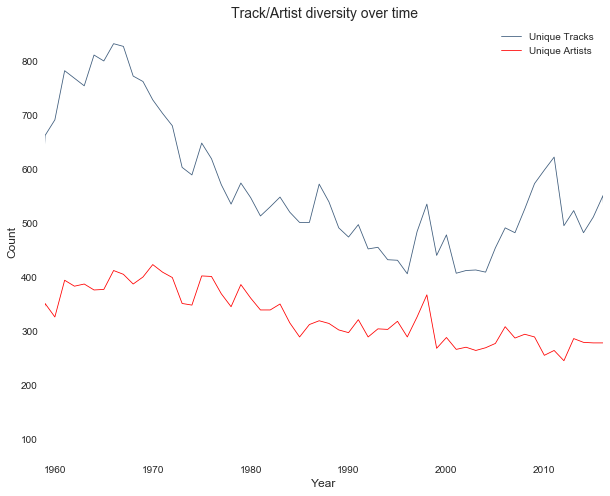

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(yearly_track_count.year, yearly_track_count.artist, color="#3F5D7D", linewidth=0.8,label="Unique Tracks")
plt.plot(yearly_tracks.year, yearly_tracks.unique_artist_count, color="red", linewidth=0.8,label="Unique Artists")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Track/Artist diversity over time', fontsize=14)
plt.xlim([1959,2016])
plt.legend()
plt.show()

We see that during the 1960's there were many more unique tracks making the Billboard Hot 100. This could be a attributed to the lack of options for people to listen to music and radio was the main medium so listeners would likely tire of the same songs more quickly so it's possible that songs didn't stay on the charts for very long. 

The number of unique tracks steadily declined until 1997 where there was a slight uptick again and the amount increased again through the mid 2000's which could be a result in the change in how song popularity is counted by taking internet download/streaming into account.

The number of unique artists followed a similar trajectory although the difference was not that large and without a noticeable increase in the 2000's.

** We expect to see an inverse relationship between the number of unique tracks in the Billboard Hot 100 and the average number of weeks a track spends on the chart. **

In [10]:
week_count=year_data.groupby(["artist","title", "year"]).max().reset_index()
week_average=week_count.groupby(["year"]).mean().reset_index()

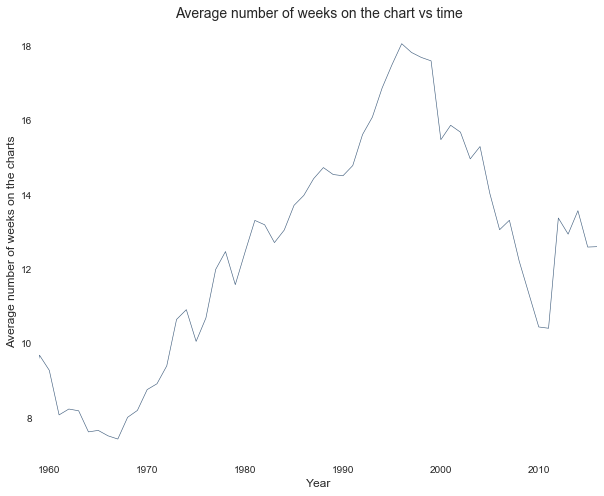

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(week_average.year, week_average.weeks, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average number of weeks on the charts', fontsize=12)
plt.title('Average number of weeks on the chart vs time', fontsize=14)
plt.xlim([1959,2016])
plt.show()

As we expected, tracks began spending a lot more time on the charts on average starting in the late 1960's up until the mid 1990's where the average decreased until 2011. 

## What is the relationship between the average number of weeks spent on the chart versus the number of unique tracks?

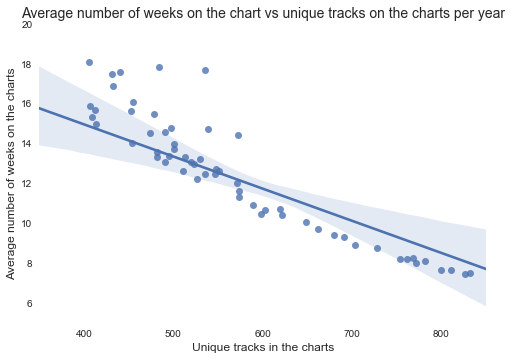

In [12]:
ax= sns.regplot(yearly_track_count.artist,y=week_average.weeks)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlabel('Unique tracks in the charts', fontsize=12)
plt.ylabel('Average number of weeks on the charts', fontsize=12)
plt.title('Average number of weeks on the chart vs unique tracks on the charts per year', fontsize=14)
# The limits on the x-axis are chosen to ignore the data from 1958 and 2017 which are incomplete.
plt.xlim([350,850])
plt.ylim([5,20])
plt.show()
sns.plt.show()

We see the expected negative correlation between the two features.

Along with unique tracks we are also interested in artists that have only made the Billboard Hot 100 one time, so-called one-hit wonders. We investigate the number of one-hit wonders by year.

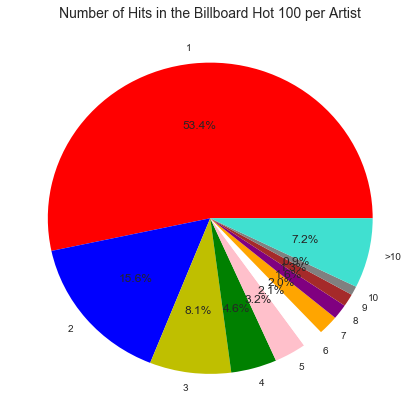

In [13]:
one_hits=year_data.groupby(["artist","title"]).count().reset_index()
one_hits=one_hits[["artist","title"]]
# We only count the main artist when considering tracks featuring multiple artists.
for row in range(0,len(one_hits)):
    artist_array = re.split(r'.Featuring+', one_hits.iloc[row,0])
    one_hits.iloc[row,0]=artist_array[0]
one_hits_new=one_hits.groupby(["artist"]).count().reset_index()
hit_count=one_hits_new.sort_values(by="title",ascending=False)
hit_count.columns=["artist","counted"]
# group data by number of hits
hit_percent=pd.DataFrame()
sum_count=0
for i in range(1,11):
    percent_count=len(hit_count[hit_count.counted==i])/len(hit_count)*100
    sum_count+=percent_count
    add_frame = {"number_of_hits":str(i), "song_percent": percent_count}
    hit_percent = hit_percent.append(add_frame,ignore_index=True)
add_end_frame={"number_of_hits":">10", "song_percent": 100-sum_count}
hit_percent=hit_percent.append(add_end_frame,ignore_index=True)
colors = ['r','b' , 'y', 'g','pink','w','orange','purple','brown','grey','turquoise']
labels_song_count = hit_percent.number_of_hits
fig, ax = plt.subplots(figsize=(6, 6))  # make the plot square
pie = ax.pie(hit_percent.song_percent, colors=colors, labels=labels_song_count,autopct='%1.1f%%')
plt.title('Number of Hits in the Billboard Hot 100 per Artist',fontsize=14)
plt.tight_layout()
plt.show()

## Which artists have the most songs in the Billboard Hot 100?

In [14]:
hit_count.head(15)

,artist,counted
2524,Glee Cast,205
1899,Drake,78
6151,Taylor Swift,67
331,Aretha Franklin,66
6272,The Beatles,65
2037,Elton John,62
4155,Madonna,59
6956,The Rolling Stones,57
6000,Stevie Wonder,55
6271,The Beach Boys,54


The big take away from this is how massively popular Glee was. In the five years between 2009 and 2013 they had 205 songs chart on the Billboard Hot 100 which is more than double the number of hits for the next highest ranked artist. Drake and Taylor Swift make up the next two highest positions despite having smaller discographies than a lot of the older artists, but due to the way that songs are currently counted, for big artists today every song on their albums can end up charting whereas in the past not every song on the album was released as a single. This suggests that artist name may be by far the biggest predictor of whether or not a song will perform well on the Billbaord Hot 100.

## Has the percentage of one hit wonders changed over time? 

In [15]:
one_hits=artist_count.groupby(["artist"]).count().reset_index()
# We only count the main artist when considering tracks featuring multiple artists.
for row in range(0,len(one_hits)):
    artist_array = re.split(r'.Featuring+', one_hits.iloc[row,0])
    one_hits.iloc[row,0]=artist_array[0]
one_hits_new=one_hits.groupby(["artist"]).sum().reset_index()
# We make a logistic column of 1 if the artist has only one track in the Billboard Hot 100 for all years and
# and 0 if the artist appears as the main artist on at least two different tracks in any years.
one_hits_count=pd.DataFrame()
for row in range(0,len(one_hits_new)):
    if one_hits_new.iloc[row,1]>1:
        one_hit_id=0
    else:
        one_hit_id=1
    add_frame = {"artist":one_hits_new.iloc[row,0], "one_hit_wonder": one_hit_id}
    one_hits_count = one_hits_count.append(add_frame,ignore_index=True)
num_hits=artist_count.groupby(["artist","year"]).count().reset_index()
one_hit_merge=pd.merge(one_hits_count,num_hits, how="outer",left_on="artist",right_on="artist")
one_hit_percent=one_hit_merge.groupby("year").mean().reset_index()

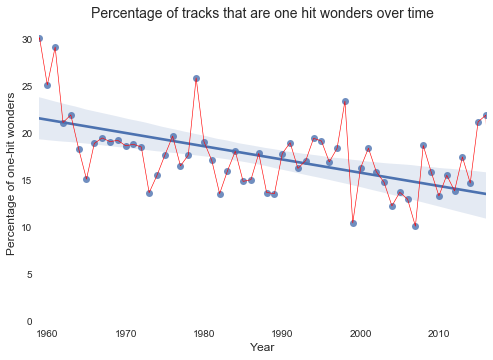

In [16]:
ax = sns.regplot(x="year",y=one_hit_percent.one_hit_wonder*100,data=one_hit_percent)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(one_hit_percent.year, one_hit_percent.one_hit_wonder*100, color="red", linewidth=0.6)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of one-hit wonders', fontsize=12)
plt.title('Percentage of tracks that are one hit wonders over time', fontsize=14)
plt.xlim([1959,2016])
sns.plt.show()
plt.show()

** The percentage of one-hit wonders seems to have decreased over time, but is this really the case? **

On December 5, 1998, the Billboard Hot 100 changed from being a "singles" chart to a "songs" chart, which allowed non-single tracks to be counted. We separate the data into two sets 1959-1998 and 1999-2016 and compare the average percentage of one-hit wonders each year.

## Hypothesis Test: Percentage of one-hit wonders

$$H_0: \mu_\text{old} - \mu_\text{new} = 0$$

$$H_a: \mu_\text{old} - \mu_\text{new} \neq 0$$

In [17]:
old_ones=one_hit_percent[1:41]
new_ones=one_hit_percent[41:-1]
z,p= stats.ttest_ind(old_ones.one_hit_wonder, new_ones.one_hit_wonder,equal_var=False)
cm = sms.CompareMeans(sms.DescrStatsW(old_ones.one_hit_wonder), sms.DescrStatsW(new_ones.one_hit_wonder))
conf_low,conf_high =cm.tconfint_diff(alpha = 0.05,usevar='unequal')
print("Z-Statistic: ", z)
print("95% Confidence Interval: ", (conf_low,conf_high))
print("p-value: ",p)

Z-Statistic:  3.33734125542
95% Confidence Interval:  (0.012807220918658407, 0.052311307043165584)
p-value:  0.00190495805707


We obtain a p-value that is close to zero and with a statistical significance of alpha = 0.05 we obtain a 95% confidence interval that the true mean difference lies between 1.2% and 5.2%. 

** Thus we reject the null hypothesis. ** 

We conclude that the percentage of tracks on the chart coming from artists that are one-hit wonders has decreased recently but the difference is not very significant.

# 6. Exploratory Data Analysis on the Spotify Audio Metadata

## What is the percentage of songs with Spotify audio metadata?

In [18]:
# First we created a subset of individual tracks from the merged_data dataframe by subsetting by the "title" and "artist" variables.
search_data=merged_data.groupby(["title","artist"]).size().reset_index()
print("{0:.2f}%".format(len(spotify_data)/len(search_data)*100))

78.33%


** We now plot histograms of several of the Spotify audio metadata features. **

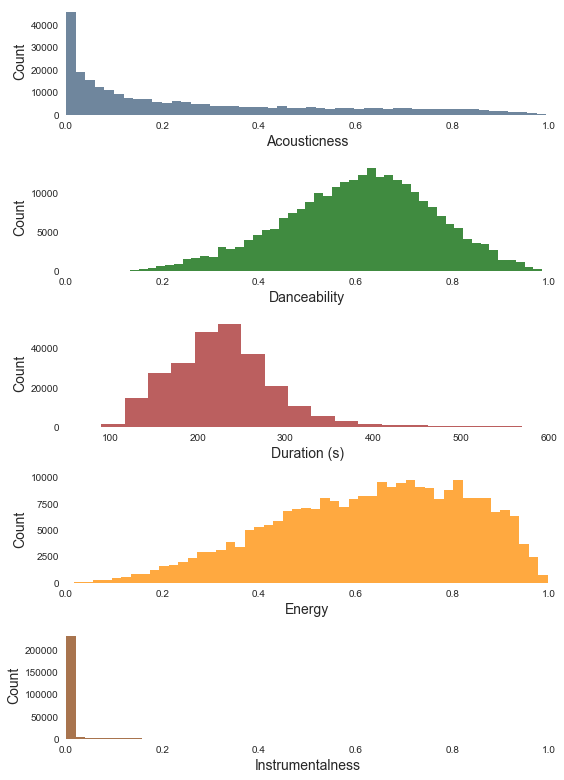

In [19]:
fig = plt.figure(figsize=(8,11))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(big_dataset.acousticness.dropna(), color="#3F5D7D", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Acousticness", fontsize=14)
plt.ylabel('Count', fontsize=14)

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.xlim(0,1)
plt.hist(big_dataset.danceability.dropna(), color="#006400", bins=50,alpha=0.75)
plt.xlabel("Danceability", fontsize=14)
plt.ylabel('Count', fontsize=14)

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.hist(big_dataset.duration_ms.dropna()/1000, color="#a52a2a", bins=50,alpha=0.75)
plt.xlim(50,600)
plt.xlabel("Duration (s)", fontsize=14)
plt.ylabel('Count', fontsize=14)


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.hist(big_dataset.energy.dropna(), color="#ff8c00",bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Energy", fontsize=14)
plt.ylabel('Count', fontsize=14)

axfive=plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.hist(big_dataset.instrumentalness.dropna(), color="#8b4513",bins=50,alpha=0.75)
plt.xlabel("Instrumentalness", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("metadata_histograms.png", bbox_inches="tight"); 
plt.show()



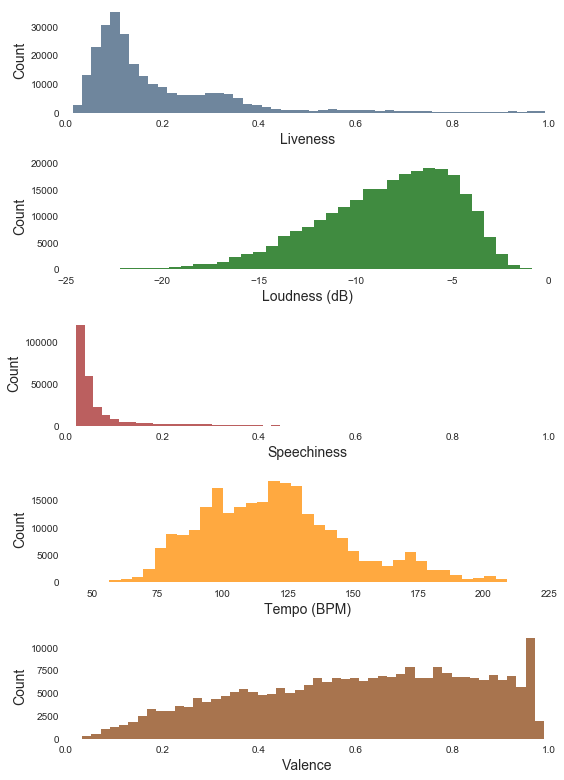

In [20]:
fig = plt.figure(figsize=(8, 11))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(big_dataset.liveness.dropna(), color="#3F5D7D", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Liveness", fontsize=14)
plt.ylabel('Count', fontsize=14)

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.xlim(-25,0)
plt.hist(big_dataset.loudness.dropna(), color="#006400", bins=50,alpha=0.75)
plt.xlabel("Loudness (dB)", fontsize=14)
plt.ylabel('Count', fontsize=14)

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.hist(big_dataset.speechiness.dropna(), color="#a52a2a", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Speechiness", fontsize=14)
plt.ylabel('Count', fontsize=14)


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.hist(big_dataset.tempo.dropna(), color="#ff8c00",bins=50,alpha=0.75)
plt.xlim(40,225)
plt.xlabel("Tempo (BPM)", fontsize=14)
plt.ylabel('Count', fontsize=14)

axfive=plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.hist(big_dataset.valence.dropna(), color="#8b4513",bins=50,alpha=0.75)
plt.xlabel("Valence", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("metadata_histograms_2.png", bbox_inches="tight"); 
plt.show()


** Things of Note:**

Acousticness, instrumentalness and speechiness all seem to be heavily skewed towards zero. This is because songs on the billboard chart usually feature electric instruments, have lyrics and are composed of very few spoken words parts respectively. On the other hand, duration, liveness,loudness and especially danceability, energy and tempo seem to be normally distributed. It would make sense that the latter features would be closely related since songs with more energy and a faster tempo are easier to dance to up to a certain point. 

## How do the audio metadata features change over time?

We subset the year data set so that we only consider the first week that the song entered the chart. 

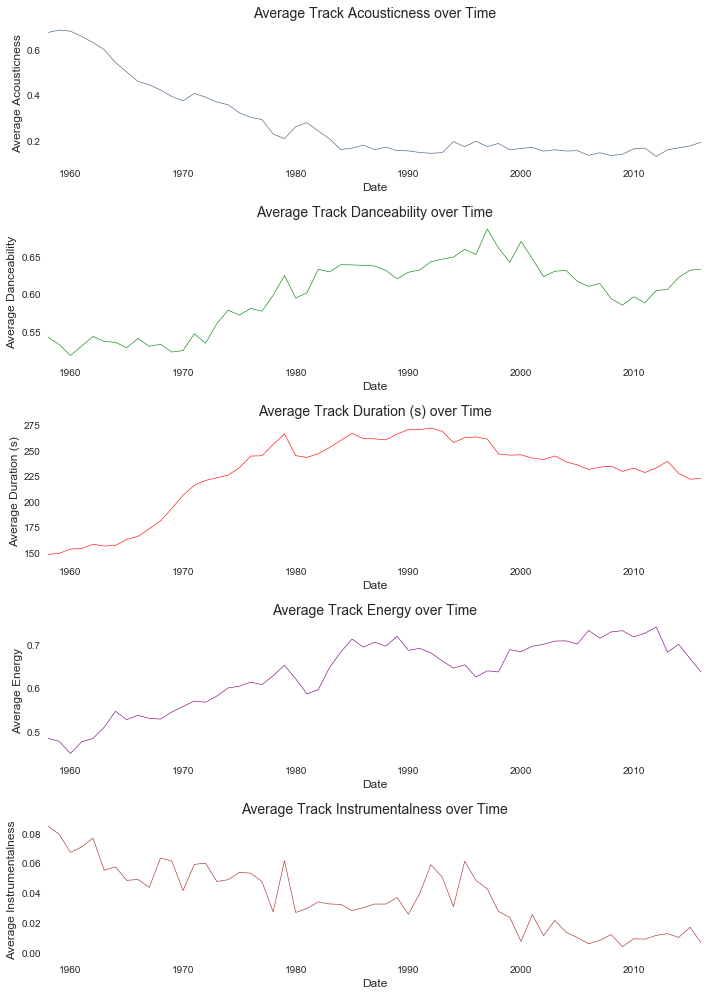

In [21]:
# Group songs by year
year_data_sub=year_data[year_data.lastPos==0]
audio_means=year_data_sub.groupby(["year"]).mean().reset_index()
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means.year, audio_means.acousticness, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Acousticness', fontsize=12)
plt.title('Average Track Acousticness over Time', fontsize=14)
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means.year,audio_means.danceability, color="green", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.title('Average Track Danceability over Time', fontsize=14)
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.duration_ms/1000, color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Duration (s)', fontsize=12)
plt.title('Average Track Duration (s) over Time', fontsize=14)
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.energy, color="purple", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Energy', fontsize=12)
plt.title('Average Track Energy over Time', fontsize=14)
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means.year,audio_means.instrumentalness, color="brown", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Instrumentalness', fontsize=12)
plt.title('Average Track Instrumentalness over Time', fontsize=14)
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

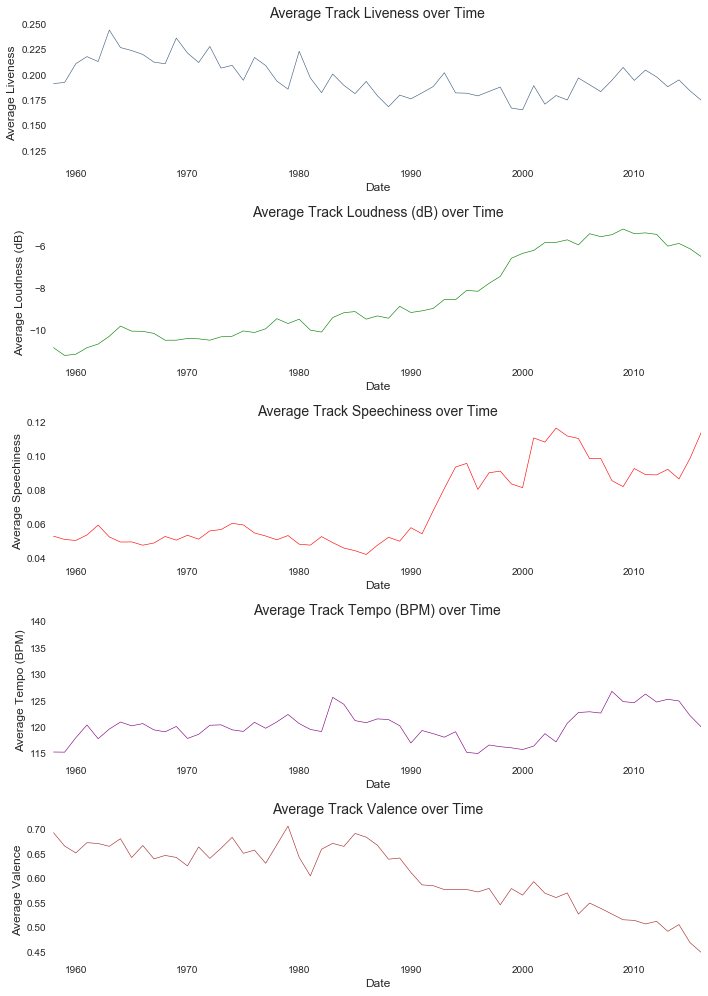

In [22]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means.year, audio_means.liveness, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Liveness', fontsize=12)
plt.title('Average Track Liveness over Time', fontsize=14)
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means.year,audio_means.loudness, color="green", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Loudness (dB)', fontsize=12)
plt.title('Average Track Loudness (dB) over Time', fontsize=14)
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.speechiness, color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Speechiness', fontsize=12)
plt.title('Average Track Speechiness over Time', fontsize=14)
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.tempo, color="purple", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Tempo (BPM)', fontsize=12)
plt.title('Average Track Tempo (BPM) over Time', fontsize=14)
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means.year,audio_means.valence, color="brown", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Valence', fontsize=12)
plt.title('Average Track Valence over Time', fontsize=14)
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

** Things of Note:**

_Acousticness_: Most songs had a higher acousticness score in the 60's possibly due to the popular of rockabilly and rock and roll which steadily declined through the 70's and 80's as more electronic instruments were added.

_Danceability_: Steadily increased through the 70's possibly due to the popularity of disco and continued increasing through the 80's and 90's.

_Duration_: The average length of a song was around 2 and half minutes in the 1960's possibly tied to 7" EP format that singles were released on and increased up to a length around 4 and a half minutes through the 70's until the 80's possibly as a result of the popularity of more complicated rock songs.

_Energy_ and _Instrumentalness_: Songs have become more energetic over time, possibly related to becoming more danceable and less instrumental possibly related to the increase in speechiness.

_Loudness_: We see a sharp increase in the 90's of Loudness which can be attributed to the popularity of the CD format and  producers making songs louder so that tracks would stand out more on the radio.

_Speechiness_ and _Valence_: Speechiness increased a lot during the 90's as rap became more popular while _Valence_ decreased possibly as a result of the growing popularity of grunge and continued through the 2000's.

## What is the most popular key? 

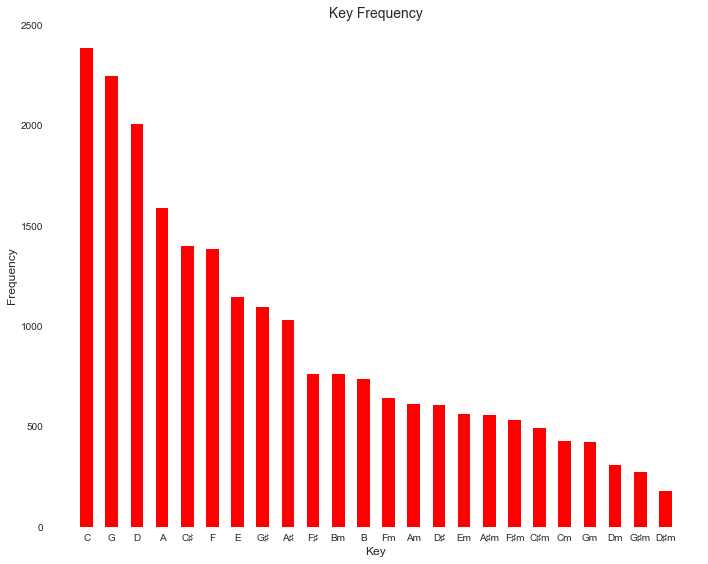

In [23]:
# First group data by artist and title
first_group_key=year_data.groupby(["artist","title","key","mode"]).count().reset_index()
# Group data by key and mode
key_data=first_group_key.groupby(["key","mode"]).count().reset_index()
# Rename keys according to letters and major or minor
key_name_list = pd.Series(["Cm","C","C♯m","C♯","Dm","D","D♯m","D♯","Em","E","Fm","F","F♯m","F♯","Gm","G","G♯m","G♯","Am","A",'A♯m',"A♯","Bm","B"])
key_name_list=key_name_list.rename("key_name")
# Join the key list to the grouped key data
key_data=pd.concat([key_data,key_name_list],axis=1)
key_data=key_data.sort_values(by="year",ascending=False)
key_list=key_data.key_name
# Plot key frequency histogram
y_pos = np.arange(len(key_list))
fig,axone=plt.subplots(figsize=(10, 8))
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.bar(y_pos, key_data.year, width=0.5,color="red")
plt.xticks(y_pos,key_data.key_name)
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Key Frequency',fontsize=14)
plt.tight_layout()
plt.show()

** We see that most popular songs are in the key of C major closely followed by G major. **
This is likely a result of the fact that these keys are easy to play on both piano and guitar.
In fact many songs are not only in the same key, but also the same chord progression as well. See this song https://www.youtube.com/watch?v=oOlDewpCfZQ by the Axis of Awesome for reference.

It's also clear that major keys are much more popular than songs in minor keys.


**Note** that this differs slightly from the analysis of all songs on Spotify which found that the most popular key is G major. 


https://insights.spotify.com/us/2015/05/06/most-popular-keys-on-spotify/ 

## What is the most common time signature?

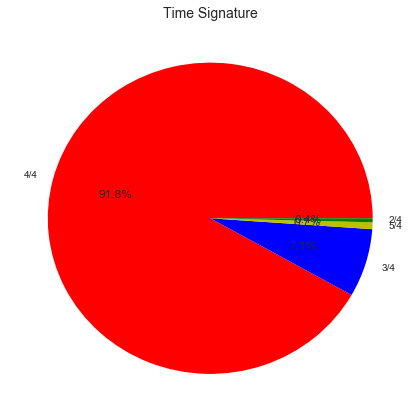

In [24]:
# First group data by artist and title
first_group_time=year_data.groupby(["artist","title",  "time_signature"]).count().reset_index()
# group data by time signature
time_data=first_group_time.groupby(["time_signature"]).count().reset_index().sort_values(by="year",ascending=False)
time_data["percent"]=time_data.year/len(first_group_time[first_group_time.time_signature.notnull()])
times = time_data.percent
colors = ['r','b' , 'y', 'g']
labels_time = ["4/4", "3/4", "5/4","2/4"]
fig, ax = plt.subplots(figsize=(6, 6))  # make the plot square
pie = ax.pie(times, colors=colors, labels=labels_time,autopct='%1.1f%%')
plt.title('Time Signature',fontsize=14)
plt.tight_layout()
plt.show()

** Here we see that the vast majority of songs on the Billboard Hot 100 are written in 4/4 Time. **

## Has key popularity changed over time?

In [25]:
#Create a pivot table to apply KMeans clustering
key_names = key_data[["key","mode","key_name"]]
key_merged = pd.merge(year_data,key_names, how="outer", left_on=["key","mode"],right_on=["key","mode"]).dropna()
key_year_new=key_merged.groupby(["artist","title","year","key_name"]).count().reset_index()
key_year_second_sub=key_year_new.groupby(["year","key_name"]).count().reset_index()
key_subset=key_year_second_sub[["year","key_name","chartDate"]]
key_pivot=key_subset.pivot_table(index=["year"],columns=["key_name"])
key_pivot=key_pivot.fillna(0).reset_index()

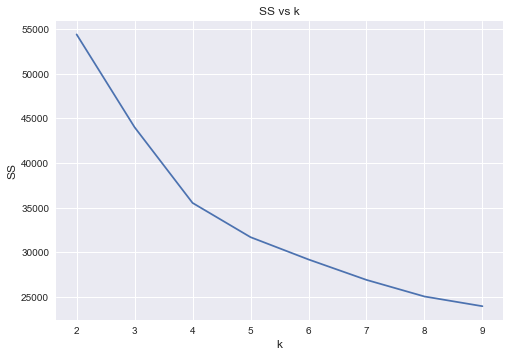

In [26]:
x_cols = key_pivot[key_pivot.columns[1:]]
Ks = range(2, 10)
# Apply KMeans clustering for each k
km = [KMeans(n_clusters=k).fit(x_cols) for k in Ks]
# The sum-of-squares error in each cluster against KK
score = [-km[i].fit(x_cols).score(x_cols) for i in range(len(km))]
# Construct a plot showing SSSS for each KK and pick KK using this plot. For simplicity, test 2≤K≤102≤K≤10. 
plt.plot(Ks, score)
plt.xlabel('k', size=12)
plt.ylabel('SS', size=12)
plt.title('SS vs k')
plt.show()

** We choose k=5 for our number of clusters. **

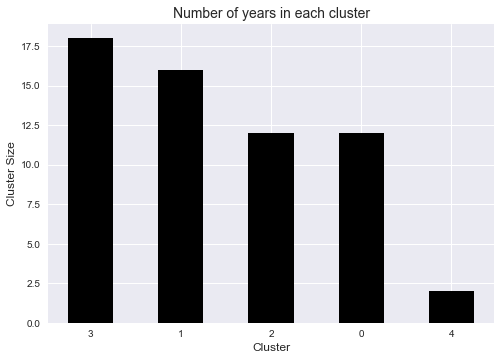

In [27]:
# We make a bar chart showing the number of points in each cluster for k-means under the best KK. 
# We use 4 for the best number of clusters.
key_pivot['cluster'] = KMeans(n_clusters=5).fit_predict(x_cols)
width = 1/2
y = pd.DataFrame(key_pivot.cluster.value_counts()).reset_index()
y.columns=["cluster","counted"]
x = np.arange(len(y))
plt.bar(x, y.counted, width, color="black")
plt.xticks(x,y.cluster)
plt.xlabel('Cluster', size=12)
plt.ylabel('Cluster Size', size=12)
plt.title('Number of years in each cluster',size=14)
plt.show()

**It's clear that cluster four represents the years 1958 and 2017 since there is less data for those years. What can we say about the other four clusters? **

In [28]:
key_cluster_zero=key_pivot[key_pivot.cluster==0]
key_cluster_one=key_pivot[key_pivot.cluster==1]
key_cluster_two=key_pivot[key_pivot.cluster==2]
key_cluster_three=key_pivot[key_pivot.cluster==3]
print("Cluster zero:", key_cluster_zero.year.unique())
print("Cluster one:", key_cluster_one.year.unique())
print("Cluster two:", key_cluster_two.year.unique())
print("Cluster three:", key_cluster_three.year.unique())

Cluster zero: [ 1959.  1960.  1961.  1962.  1963.  1964.  1965.  1966.  1967.  1968.
  1969.  1970.]
Cluster one: [ 1989.  1990.  1991.  1992.  1993.  1994.  1995.  1996.  1997.  1998.
  1999.  2000.  2001.  2002.  2003.  2004.]
Cluster two: [ 2005.  2006.  2007.  2008.  2009.  2010.  2011.  2012.  2013.  2014.
  2015.  2016.]
Cluster three: [ 1971.  1972.  1973.  1974.  1975.  1976.  1977.  1978.  1979.  1980.
  1981.  1982.  1983.  1984.  1985.  1986.  1987.  1988.]


** We have that cluster zero represents the earliest years on the charts, followed by cluster three, cluster one represents the 90's and early 2000's and cluster two represents every year since 2005. **

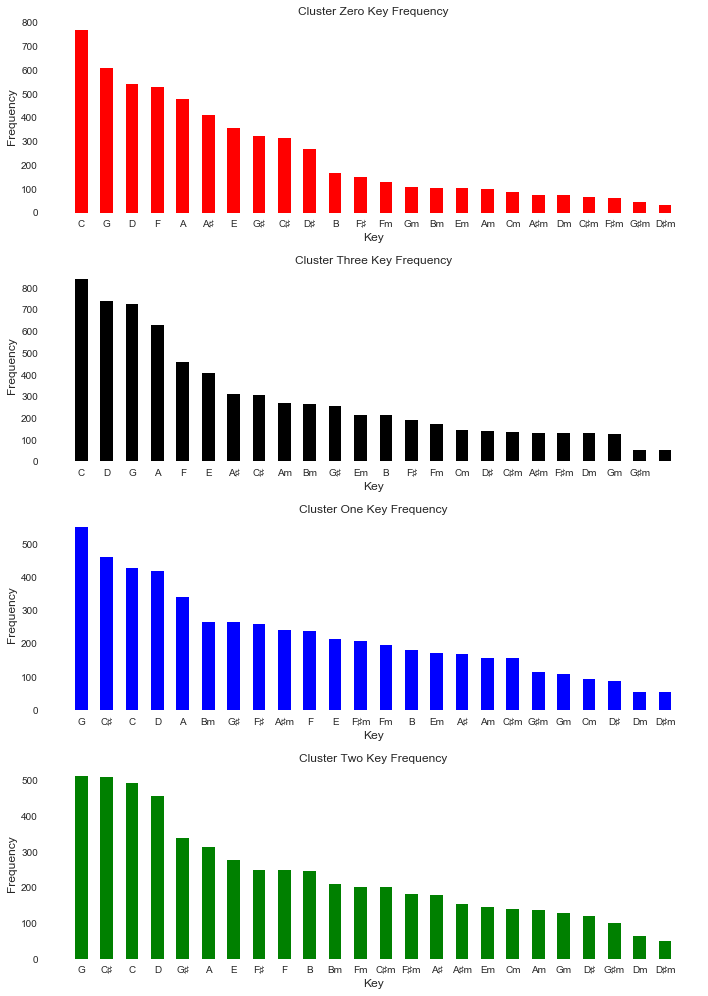

In [47]:
cluster_zero_sum=key_cluster_zero.sum().reset_index()
cluster_zero_sum.columns=["chartDate",  "key_name","counted"]
cluster_one_sum=key_cluster_one.sum().reset_index()
cluster_one_sum.columns=["chartDate","key_name","counted"]
cluster_two_sum=key_cluster_two.sum().reset_index()
cluster_two_sum.columns=["chartDate", "key_name","counted"]
cluster_three_sum=key_cluster_three.sum().reset_index()
cluster_three_sum.columns=["chartDate", "key_name","counted"]

fig = plt.figure(figsize=(10, 14))
key_zero_sorted=cluster_zero_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_zero_sorted=key_zero_sorted[1:25]
key_list_zero_sorted=key_zero_sorted.key_name
y_pos = np.arange(len(key_list_zero_sorted))
axzero=plt.subplot(4,1,1)
axzero.spines["top"].set_visible(False)  
axzero.spines["right"].set_visible(False)
axzero.set_facecolor('white')
axzero.get_xaxis().tick_bottom()  
axzero.get_yaxis().tick_left()
plt.bar(y_pos, key_zero_sorted.counted, width=0.5,color="red")
plt.xticks(y_pos,key_zero_sorted.key_name)
plt.title("Cluster Zero Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

axone=plt.subplot(4,1,3)
key_one_sorted=cluster_one_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_one_sorted=key_one_sorted[1:25]
key_list_one_sorted=key_one_sorted.key_name
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.bar(y_pos, key_one_sorted.counted, width=0.5,color="blue")
plt.xticks(y_pos,key_one_sorted.key_name)
plt.title("Cluster One Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

axtwo=plt.subplot(4,1,4)
key_two_sorted=cluster_two_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_two_sorted=key_two_sorted[1:25]
key_list_two_sorted=key_two_sorted.key_name
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left()
plt.bar(y_pos, key_two_sorted.counted, width=0.5,color="green")
plt.xticks(y_pos,key_two_sorted.key_name)
plt.title("Cluster Two Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)


axtwo=plt.subplot(4,1,2)
key_three_sorted=cluster_three_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_three_sorted=key_three_sorted[1:25]
key_list_three_sorted=key_three_sorted.key_name
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left()
plt.bar(y_pos, key_three_sorted.counted, width=0.5,color="black")
plt.xticks(y_pos,key_three_sorted.key_name)
plt.title("Cluster Three Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

** One interesting discovery is that the key C♯ has become much more popular over time and is now tied with G for the most popular key whereas D♯ has become the least popular major key and is now less popular than almost all minor keys. **

** Speculation**: Now that rock music is no longer the dominant genre it once was, there are less songs being written with piano and guitar in mind which may explain the decrease in the popularity of songs in C and G major. 

** Furthermore **: It would be very interesting to obtain reliable genre data for the Billboard Hot 100 songs to see if this can explain the change in key popularity.

# 7. Exploratory Data Analysis on the Lyrics

## How many tracks have lyrics? From which sources? 

In [48]:
source_data=pd.DataFrame()
lyrics_count = len(lyrics_sub[lyrics_sub.source ==0])+len(lyrics_sub[lyrics_sub.source==1])
source_data = source_data.append({"source":"metrolyrics.com","lyrics count":lyrics_count},ignore_index=True)
lyrics_sources = ["songlyrics.com","lyricsmode.com","azlyrics.com","musixmatch.com"] 
for u in range(0,len(lyrics_sources)):
    lyrics_count = len(lyrics_sub[lyrics_sub.source ==u+2])
    source_data = source_data.append({"source":lyrics_sources[u],"lyrics count":lyrics_count},ignore_index=True)
no_lyrics= lyrics_sub[lyrics_sub.source.isnull()]
source_data=source_data.append({"source":"unavailable","lyrics count":len(no_lyrics)},ignore_index=True)
print("We have lyrics data for",len(lyrics_sub[lyrics_sub.lyrics.notnull()])/len(lyrics_sub)*100,"% of the tracks in the Billboard Hot 100.")
source_data

We have lyrics data for 82.6047556908801 % of the tracks in the Billboard Hot 100.


,lyrics count,source
0,14527,metrolyrics.com
1,6594,songlyrics.com
2,1650,lyricsmode.com
3,6,azlyrics.com
4,12,musixmatch.com
5,4799,unavailable


** Note: The reason azlyrics.com and musixmatch.com have such low lyrics counts besides being the 4th and 5th choices is because our IP was blocked after only a few attempts. **

## What are the most common words in the lyrics of each year?

In [49]:
# We import a list of small stopwords from the NLTK package that we do not consider when counting the most common words.
from nltk.corpus import stopwords
stop_words_set=set(stopwords.words('english'))
# The stopwords list is missing many contractions so we import these as a list as well.
contract_file = open("contractions.txt")
contraction_set = set(contract_file.read().split(','))
# Join the two sets together
stop_plus_cont=stop_words_set.union(contraction_set)
#The following is our regex for splitting the words in the lyrics into tokens.
pattern = r"""(?x)                   # set flag to allow verbose regexps
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
              |\d+(?:\.\d+)?%?       # numbers, incl. currency and percentages
              |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
              |(?:[+/\-@&*])         # special characters with meanings
            """

In [50]:
import nltk
from nltk import word_tokenize
lyrics_list=billboard_lyrics[billboard_lyrics.lyrics.notnull()].reset_index()
common_words = pd.DataFrame()
lower_limit =0
upper_limit =len(lyrics_list)
for row in range(lower_limit,upper_limit):
    row_string=lyrics_list.get_value(row,"lyrics").lower()
    row_tokens=nltk.regexp_tokenize(row_string, pattern)
    # We remove words that are only three letters or less and stop words
    row_tokens_sub=[w  for  w in row_tokens if len(w)>3 and (w not in stop_plus_cont)]
    row_text = nltk.Text(row_tokens)
    word_counts = Counter(row_tokens_sub)
    row_freq_dist=nltk.FreqDist(row_text)
    # We calculate lyric diversity as the number of unique words in the lyrics divided by the total lyrics.
    row_diversity= len(set(row_text))/len(row_text)
    add_frame = {"artist":lyrics_list.get_value(row,"artist"), "track":lyrics_list.get_value(row,"track"), "lyrics":lyrics_list.get_value(row,"lyrics"),"common words":word_counts.most_common(),"FreqDist":row_freq_dist,"Lyrical Diversity":row_diversity}
    common_words = common_words.append(add_frame,ignore_index=True)
# We group the year data by title, artist lyrics and year    
chart_year=year_data.groupby(["title","artist","lyrics","year"]).count().reset_index()
# We merge the year data with the common words dataset
chart_sub=pd.merge(common_words,chart_year,left_on=["track","artist"],right_on=["title","artist"],how="outer")
chart_sub=chart_sub[["artist","common words","title","year","Lyrical Diversity"]].sort_values(by="year")    

## Lyrical Diversity over time

We define the lyrical diversity to be the number of unique words in the lyrics divided by the total number of the words. We first remove songs with a lyrical diversity of 1 which correspond to songs where the lyrics were either not known or the track is instrumental.

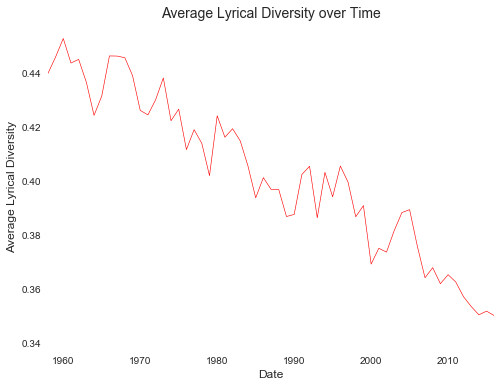

In [51]:
actual_lyrics=chart_sub[chart_sub["Lyrical Diversity"]!=1]
# Find the mean lyrical diversity for each year.
div_means=actual_lyrics.groupby(["year"]).mean().reset_index()
fig = plt.figure(figsize=(8, 6))
axone=plt.subplot(1,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(div_means.year, div_means["Lyrical Diversity"], color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Lyrical Diversity', fontsize=12)
plt.title('Average Lyrical Diversity over Time', fontsize=14)
plt.xlim([1958,2016])
plt.show()

Here we see a remarkable steep decline in the average lyrical diversity of songs on the Billboard Hot 100. Songs are becoming much simpler with more repetition.

# 8. Predicting Song Popularity from Audio Metadata

For the purposes of this project we say that a song is popular if it reaches the top ten.  This is given by songs with 'peakPos'<=10. 

**Note**: We only count each song once since if we allow for songs to be counted with multiplicity then it might be possible that every song in the test data was actually already present in the training data, which could give a misleading high accuracy score. 

In [6]:
# We import the dataset that was cleaned and wrangled in the previous steps.
all_data=pd.read_csv("all_data_spotify_lyrics.csv",encoding='latin1')
# We subset the dataset on the useful features and rename the 'Lyrical Diversity' variable.
all_data_sub=all_data[["chartDate", "title","artist","peakPos","weeks","rank", 'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence', 'year' ,'Lyrical Diversity']]
all_data_sub = all_data_sub.rename(columns={'Lyrical Diversity': 'lyrical_diversity'})

## Are the audio metadata features different for more popular songs?

In [7]:
top_ten_songs=all_data_sub[all_data_sub.peakPos<11]
audio_means_ten=top_ten_songs.groupby("year").mean().reset_index()
bottom_ninety=all_data_sub[all_data_sub.peakPos>10]
audio_means_bottom=bottom_ninety.groupby("year").mean().reset_index()
no_year_cols=["title","artist","peakPos",'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','lyrical_diversity']
group_columns = ["title","artist","peakPos",'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','lyrical_diversity','year']

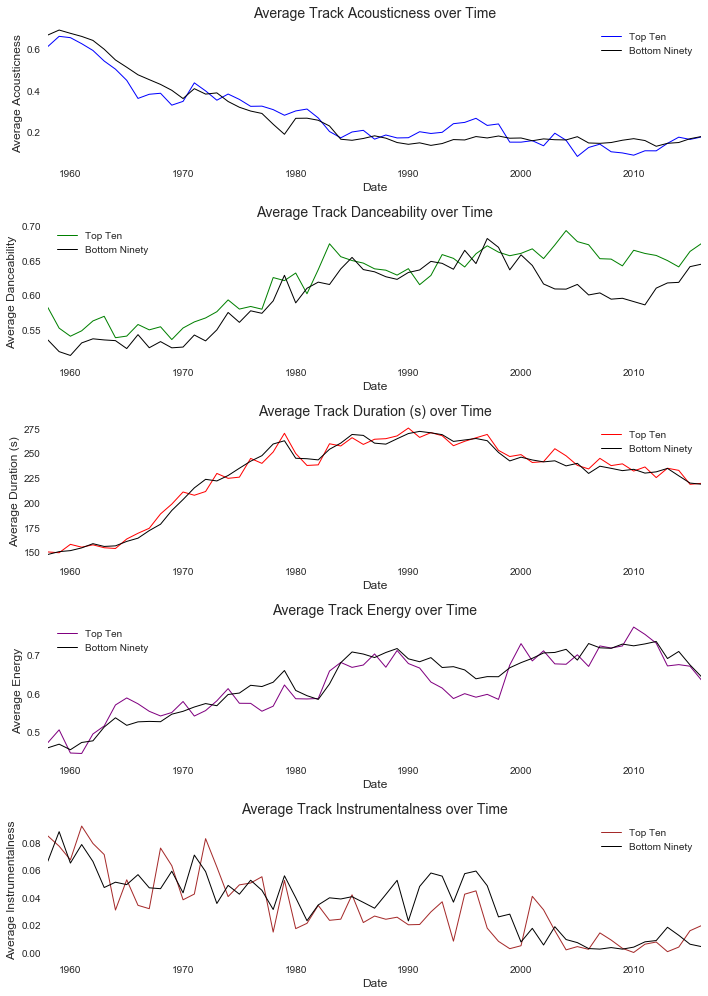

In [8]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.plot(audio_means_ten.year, audio_means_ten.acousticness, color="blue", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year, audio_means_bottom.acousticness, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Acousticness', fontsize=12)
plt.title('Average Track Acousticness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means_ten.year,audio_means_ten.danceability, color="green", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year,audio_means_bottom.danceability, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.title('Average Track Danceability over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left()
plt.plot(audio_means_ten.year, audio_means_ten.duration_ms/1000, color="red", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year, audio_means_bottom.duration_ms/1000, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Duration (s)', fontsize=12)
plt.title('Average Track Duration (s) over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means_ten.year, audio_means_ten.energy, color="purple", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year, audio_means_bottom.energy, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Energy', fontsize=12)
plt.title('Average Track Energy over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means_ten.year,audio_means_ten.instrumentalness, color="brown", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year,audio_means_bottom.instrumentalness, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Instrumentalness', fontsize=12)
plt.title('Average Track Instrumentalness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

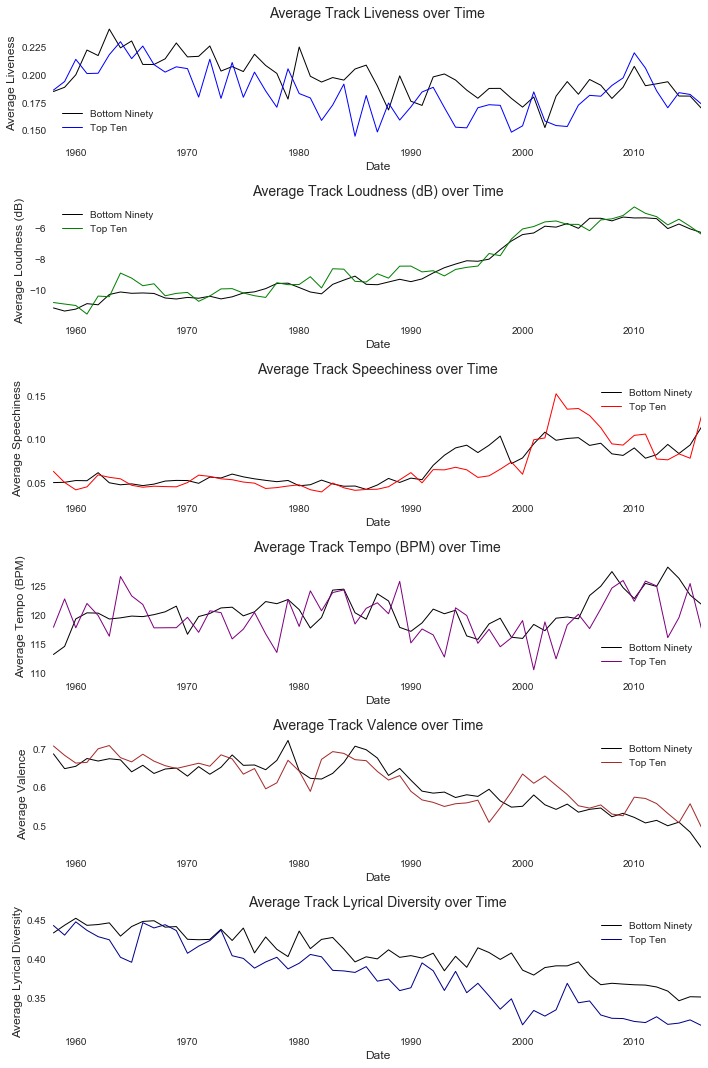

In [9]:
fig = plt.figure(figsize=(10, 15))

axone=plt.subplot(6,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means_bottom.year, audio_means_bottom.liveness, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year, audio_means_ten.liveness, color="blue", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Liveness', fontsize=12)
plt.title('Average Track Liveness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axtwo=plt.subplot(6,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means_bottom.year,audio_means_bottom.loudness, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year,audio_means_ten.loudness, color="green", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Loudness (dB)', fontsize=12)
plt.title('Average Track Loudness (dB) over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axthree=plt.subplot(6,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means_bottom.year, audio_means_bottom.speechiness, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year, audio_means_ten.speechiness, color="red", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Speechiness', fontsize=12)
plt.title('Average Track Speechiness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])


axfour=plt.subplot(6,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means_bottom.year, audio_means_bottom.tempo, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year, audio_means_ten.tempo, color="purple", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Tempo (BPM)', fontsize=12)
plt.title('Average Track Tempo (BPM) over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axfive = plt.subplot(6,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means_bottom.year,audio_means_bottom.valence, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year,audio_means_ten.valence, color="brown", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Valence', fontsize=12)
plt.title('Average Track Valence over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axsix = plt.subplot(6,1,6)
axsix.spines["top"].set_visible(False)  
axsix.spines["right"].set_visible(False)
axsix.set_facecolor('white')
axsix.get_xaxis().tick_bottom()  
axsix.get_yaxis().tick_left()
plt.plot(audio_means_bottom.year,audio_means_bottom.lyrical_diversity, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year,audio_means_ten.lyrical_diversity, color="darkblue", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Lyrical Diversity', fontsize=12)
plt.title('Average Track Lyrical Diversity over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

** Interesting observations: ** After 2000 the danceability of tracks in the top ten have been much higher than the bottom ninety. On the other hand the liveness of tracks in the top ten have almost always been less on average than the bottom ninety. The speechiness of top ten tracks was much less than the bottom ninety in the 90's, but this switched in 2001 and for the duration of the 2000's it was much higher. A similar trend is found with valence. Top ten songs had a lower valence from the mid 80's until the late 90's (which could be somewhat related to the popularity of grunge?). Then in the 2000's the top ten tracks began to have higher valence than the bottom ninety.

** Note: ** Lyrical diversity may be a very good indicator of whether a song becomes a top ten hit since top ten hits always have more repetition and after the late 90's the gap between the lyrical diversity of top ten tracks and bottom ninety has grown wider.

We now separate the songs into two categories and use a binary classifier in the 'top_ten_hit' column. We keep only the songs for which we have Spotify audio metadata. We also drop the cases for which we have lyrics data, but not Spotify data.

In [10]:
# Separate the data into songs in the top ten and songs in the bottom ninety.
top_ten_weeks=all_data_sub[all_data_sub['rank']<=10]
bottom_ninety_weeks=all_data_sub[all_data_sub['rank']>10]
top_ten_group=top_ten_weeks.groupby(no_year_cols).size().reset_index()
bottom_ninety_group=bottom_ninety_weeks.groupby(no_year_cols).size().reset_index()
# Rename column
top_ten_group.rename(columns={0:'num_weeks_top_ten'}, inplace=True)
bottom_ninety_group.rename(columns={0:'num_weeks_bottom'}, inplace=True)
# Join the top ten and bottom ninety together.
ten_ninety_join=pd.merge(top_ten_group,bottom_ninety_group, how="outer",left_on=no_year_cols,right_on=no_year_cols)
# Replace NaN's in the num_weeks_top_ten column with zeros.
ten_ninety_join=ten_ninety_join.fillna(0)
# Create a dataframe of all the unique songs with the year column.
songs_with_year=all_data_sub.groupby(group_columns).size().reset_index()
# Remove the duplicate tracks for songs that appear in the charts for two separate year by choosing the first year. 
top_ten_yearly=songs_with_year.groupby(no_year_cols).min().reset_index()
# Merge the ten_ninety_join and top_ten_yearly datasets together.
hits_with_year=pd.merge(ten_ninety_join,top_ten_yearly, how="outer",left_on=no_year_cols,right_on=no_year_cols)
# Create the top_ten_hit predictor column.
top_ten_prediction=hits_with_year[['peakPos', 'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year','num_weeks_top_ten',"num_weeks_bottom","lyrical_diversity"]]
top_ten_prediction['top_ten_hit']= (top_ten_prediction.num_weeks_top_ten >0).astype(int)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
pd.options.display.float_format = '{:20,.5f}'.format
top_ten_prediction.groupby(['top_ten_hit']).mean().reset_index()

,top_ten_hit,peakPos,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,num_weeks_top_ten,num_weeks_bottom,lyrical_diversity
0,0,51.63346,0.29511,0.58843,"222,288.12939",0.62598,0.02627,5.21967,0.20001,-8.53871,0.74056,0.07003,120.51250,3.92416,0.60102,"1,986.72509",0.00000,10.10489,0.40949
1,1,4.66271,0.29422,0.61251,"226,272.36150",0.61572,0.02598,5.18567,0.18881,-8.65452,0.72200,0.06450,119.30670,3.94526,0.62248,"1,983.89077",6.49067,13.67962,0.38642


From this initial investigation it seems like danceability, tempo and lyrical diversity may be important features to distinguish between cases. Also, from our previous observations of the averages over time we know that for certain years the averages between top ten hits and songs in the bottom ninety can differ significantly.

## Data Visualization

The key variable is an integer between zero and eleven and time signature is an integer between 2 and 5. These are not on a numerical scale so we introduce dummy indicator variables to distinguish between the cases when using regression.

In [12]:
# We can drop the 'peakPos' column when visualizing the data.
top_ten_prediction.drop(['peakPos'],axis=1,inplace=True)
# Change key and time entries to integers
top_ten_prediction.key=top_ten_prediction.key.astype(int)
top_ten_prediction.time_signature=top_ten_prediction.time_signature.astype(int)
# create dummy variables using get_dummies, then exclude the first dummy column
key_dummies = pd.get_dummies(top_ten_prediction.key, prefix='key').iloc[:, 1:]
time_dummies = pd.get_dummies(top_ten_prediction.time_signature, prefix='time').iloc[:, 1:]
# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
top_ten_no_na_dum = pd.concat([top_ten_prediction, key_dummies,time_dummies], axis=1)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\MSI_USER\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Is there any correlation between the audio metadata features?

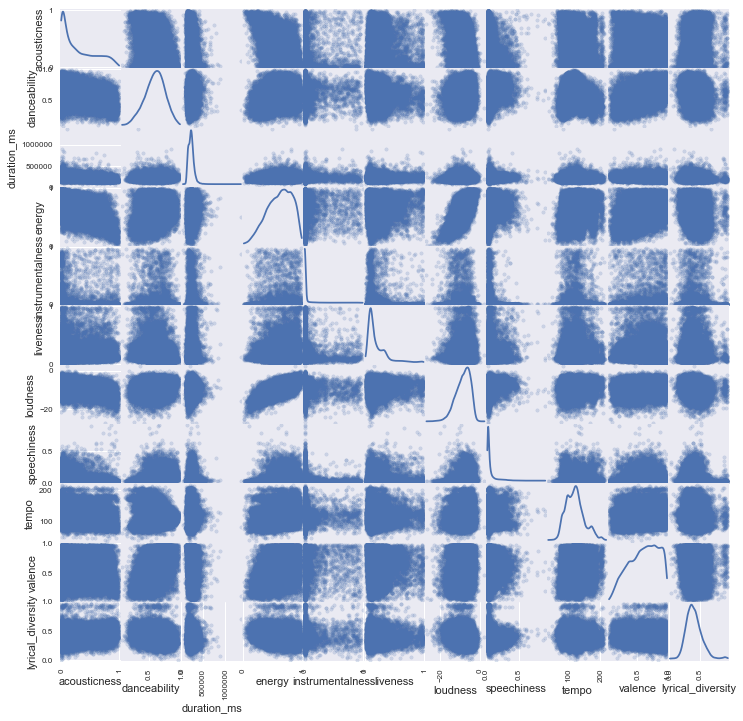

In [59]:
audio_data=top_ten_prediction[["acousticness", "danceability", "duration_ms", "energy" ,"instrumentalness", "liveness", "loudness", "speechiness", "tempo","valence","lyrical_diversity"]].dropna()
scatter_matrix(audio_data,alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

** Things of note: **
We see that instrumentalness and speechiness appear to be more of a binary relationship and there exists a clear positive relationship between loudness and energy. On the other hand, the relationship between danceability and energy does not to be as strong as we expeccted.

In [60]:
# We investigate the relationship between danceability, energy, loudness and tempo
print("Loudness and Energy:")
print(stats.linregress(audio_data.loudness,audio_data.energy))
print("")
print("Tempo and Energy:")
print(stats.linregress(audio_data.tempo,audio_data.energy))
print("")
print("Danceability and Energy:")
print(stats.linregress(audio_data.danceability,audio_data.energy))
print("")
print("Tempo and Danceability:")
print(stats.linregress(audio_data.tempo,audio_data.danceability))

Loudness and Energy:
LinregressResult(slope=0.039820836782616283, intercept=0.96484335074202221, rvalue=0.7083328124508157, pvalue=0.0, stderr=0.00028528161706240591)

Tempo and Energy:
LinregressResult(slope=0.001183971630356682, intercept=0.48148925803172199, rvalue=0.16349827778834103, pvalue=5.0166602551754213e-116, stderr=5.1358832609778851e-05)

Danceability and Energy:
LinregressResult(slope=0.28034448915742305, intercept=0.45753346729910044, rvalue=0.21070966118980181, pvalue=4.1907473099143639e-193, stderr=0.0093501097761547886)

Tempo and Danceability:
LinregressResult(slope=-0.00092217961976629316, intercept=0.70427180627012242, rvalue=-0.16943182191264022, pvalue=1.4070767808903888e-124, stderr=3.8562605940465048e-05)


** For loudness and energy we get an r^2 value of 0.7083 which indicates that there is indeed a strong positive relationship. For the others the correlation is not very strong. **

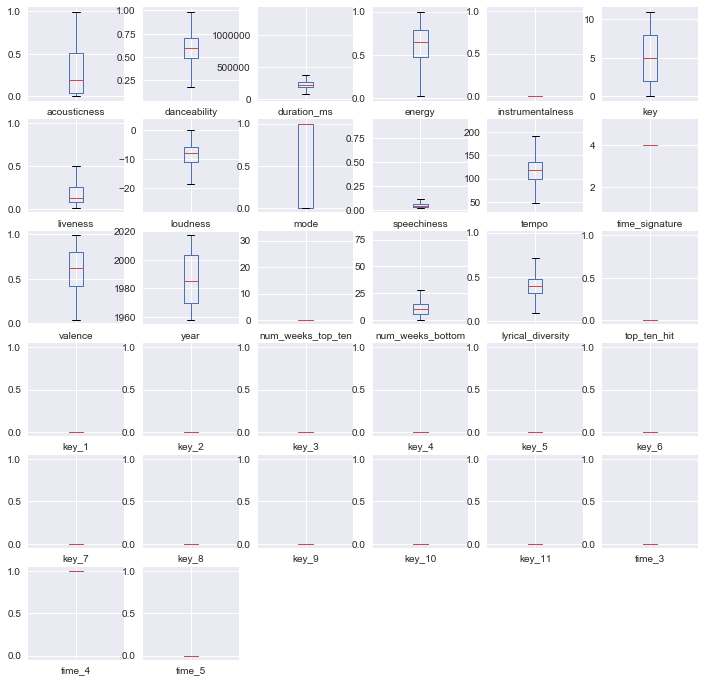

In [61]:
# We perform a box and whiskers plot of the features
top_ten_no_na_dum.plot(kind='box', subplots=True,layout=(6,6), figsize=(12, 12), sharex=False, sharey=False)
plt.show()

From these observations we see there are a few outliers for the duration and speechiness variables. We now investigate for other outliers.

## Outlier Detection

From the distributions above we see that 'lyrical_diversity', 'danceability', 'duration_ms', 'energy', 'loudness', and 'tempo' have distributions that appear somewhat normal so we look for outliers from these features by checking for songs with observations that are more than two standard deviations away from the means.

In [62]:
top_ten_outliers=top_ten_prediction[['danceability','duration_ms','energy','loudness','tempo', 'lyrical_diversity']]
outliers=pd.DataFrame()
for column in top_ten_outliers.columns:
    mean = np.mean(top_ten_outliers[column], axis=0)
    sd = np.std(top_ten_outliers[column], axis=0)
    column_outliers_small=top_ten_outliers[top_ten_outliers[column]< mean-2*sd]
    column_outliers_large=top_ten_outliers[top_ten_outliers[column]> mean+2*sd]
    outliers=pd.concat([outliers,column_outliers_small],axis=0)
    outliers=pd.concat([outliers,column_outliers_large],axis=0)
print("Number of outliers: ", len(outliers))
print("Percentage of total dataset: ", len(outliers)/len(top_ten_outliers)*100)

Number of outliers:  4374
Percentage of total dataset:  22.60348302413312


We obtain 4374 outliers. Since these make up a rather large percentage of the overall size of the dataset, we do not remove these songs in our analysis.

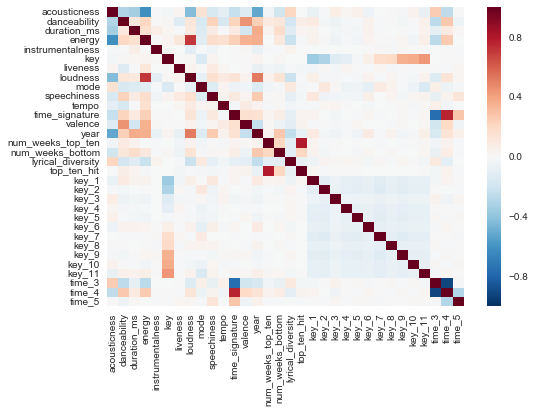

In [63]:
corr = top_ten_no_na_dum.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

From this we see a high positive correlation between energy and loudness and high negative correlation between acousticness and both loudness and energy. 

We drop time_signature and key since these are explained by the dummy variables.

In [13]:
top_ten_no_na_dum.drop(['key','time_signature'],axis=1,inplace=True)
linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','mode','speechiness','tempo','valence','key_1','key_2','key_3','key_4','key_5','key_7','key_8','key_9','key_10','key_11','time_3','time_4','time_5','year','lyrical_diversity']

## VIF Variance Inflation Factor

The Correlation matrix above is used to detect colinearity between two variables. However, multicolinearity is a measurement of correlation from three or more variables and can emerge even when isolated pairs of variables are not colinear.

We use the Variance Inflation Factor (VIF) as a measure of colinearity among predictor variables within a multiple regression. It is given by the formula: $ VIF = 1 / (1 - R^2). $

In [65]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

feature_cols_str = "+".join(linear_feature_cols)
# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('top_ten_hit ~' + feature_cols_str, top_ten_no_na_dum, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif

,VIF Factor,features
0,"29,728.98353",Intercept
1,2.11401,acousticness
2,1.83570,danceability
3,1.30196,duration_ms
4,3.65514,energy
5,1.03402,instrumentalness
6,1.08141,liveness
7,2.70761,loudness
8,1.10904,mode
9,1.18244,speechiness


We see that there is some degree of multi-colinearity between time_3 and time_4. Over 90% of the songs were in 4/4 time so it will not be a very good feature to use for prediction so we remove it from our dataset.

In [14]:
top_ten_no_na_dum.drop(['time_4'],axis=1,inplace=True)

# 9. Machine Learning Modeling 

In [15]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import r2_score

C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [21]:
sum(top_ten_prediction.top_ten_hit)/len(top_ten_prediction)*100

20.484729471345151

From this we see that 20.484% of the songs in our dataset are top ten hits. Thus, when modeling we can obtain a 79.516% accuracy score just by always predicting that the song is not a top ten hit. 

We have that 'top_ten_hit' is the target variable in our classification problem. To account for this imbalance in positive and negative samples we use oversampling to ensure that relative class frequencies are approximately preserved in each train and validation fold.

## Classification Algorithm
We write the following classification algorithm that we can use with multiple machine learning models given a dataset, target variable and hyperparameters. We use SMOTE - Synthetic Minority Over-sampling Technique to account for our imbalanced dataset. 

In [16]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False,seed = 7):
    #To create the 'X' dataset we first standardize by the mean and standard deviation is standardize is set to True
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    #Create the 'X' and 'y' datasets
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    # Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
    clf = clf()
    # Now implement GridSearchCV for the cross validation step 
    grid_clf = GridSearchCV(clf, parameters, cv = 5, scoring = 'roc_auc')
    # Use the classifier to fit the training data
    grid_clf.fit(Xtrain, ytrain)
    grid_est=grid_clf.best_estimator_
    print("BEST PARAMS", grid_clf.best_params_)
    clf_model = grid_est.fit(Xtrain, ytrain)
    predicted=clf_model.predict_proba(Xtest)[:,1]
    fpr, tpr, threshhold = roc_curve(ytest, predicted)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return clf_model

In [16]:
# We use a 80-20 Train-Test split by default and do not standardize the audiodata metadata features
# We set the seed to 7 to obtain consistent results
#def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False,seed = 7):
#    #To create the 'X' dataset we first standardize by the mean and standard deviation is standardize is set to True
#    subdf=indf[featurenames]
#    if standardize:
#        subdfstd=(subdf - subdf.mean())/subdf.std()
#    else:
#        subdfstd=subdf
    #Create the 'X' and 'y' datasets
#    X=subdfstd.values
#    y=(indf[targetname].values==target1val)*1
    # Split X and y into training and test data.
#    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
#       clf = clf()
    # Now implement GridSearchCV for the cross validation step 
#    grid_clf = GridSearchCV(clf, parameters, cv = 5, scoring = 'roc_auc')
    # Use the classifier to fit the training data
#    grid_clf.fit(Xtrain, ytrain)
#    grid_est=grid_clf.best_estimator_
#    print("BEST PARAMS", grid_clf.best_params_)
    # Use oversampling with SMOTE to account for imbalanced data
#    smote = SMOTE(random_state=seed)
#    smote_model = make_pipeline(smote, grid_est)
#    smote_model = smote_model.fit(Xtrain, ytrain)
#    preds = smote_model.predict_proba(Xtest)[:,1]
#    fpr, tpr, threshhold = roc_curve(ytest, preds)
#    training_accuracy = smote_model.score(Xtrain, ytrain)
#    test_accuracy = smote_model.score(Xtest, ytest)
#    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
#    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    #test_prediction=smote_model.predict(Xtest)
#    test_prediction=grid_est.predict(Xtest)
#    print(confusion_matrix(ytest,test_prediction))
#    print(classification_report(ytest,test_prediction))
#    roc_auc = auc(fpr, tpr)
#    plt.title('ROC Curve of SMOTE')
#    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#    plt.legend(loc = 'lower right')
#    plt.plot([0, 1], [0, 1],'r--')
#    plt.xlim([0, 1])
#    plt.ylim([0, 1])
#    plt.ylabel('True Positive Rate')
#    plt.xlabel('False Positive Rate')
#    plt.show()
#    return smote_model,grid_est

Since our question is primarily a binary classification problem, we begin with Logistic Regression.

## Logistic Regression

BEST PARAMS {'C': 0.001, 'class_weight': {0: 0.79516, 1: 0.20484}}


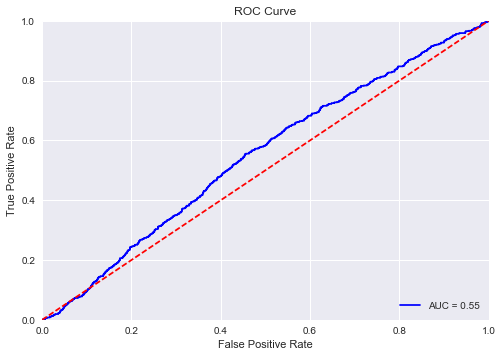

In [23]:
linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','mode','speechiness','tempo','valence','key_1','key_2','key_3','key_4','key_5','key_7','key_8','key_9','key_10','key_11','time_3','time_5','year','lyrical_diversity']
from sklearn.linear_model import LogisticRegression
params = {"C": [0.001, 0.1, 1, 10, 100],'class_weight':[{0:0.79516, 1:0.20484}]}
clf_log= do_classify(LogisticRegression, params, top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)

In [24]:
pd.options.display.float_format = '{:20,.5f}'.format
pd.DataFrame({"feature":linear_feature_cols,"log_coefficient":clf_log.coef_[0]})

,feature,log_coefficient
0,acousticness,-0.00000
1,danceability,-0.00000
2,duration_ms,0.00000
3,energy,-0.00000
4,instrumentalness,-0.00000
5,liveness,-0.00000
6,loudness,0.00001
7,mode,-0.00000
8,speechiness,-0.00000
9,tempo,-0.00010


From the ROC curve and coefficients we see that Logistic Regression does not produce a model that is much more accurate than the trivial model. Thus the features do not have much influence on the model.

## Ridge Regression, Lasso Regression and Elastic Net Regression
Since we have a classification problem, and these models are linear in nature we do not implement them here.

## Decision Tree
In a Decision Tree we have a number of parameters we can tune. 
- Criterion measures the quality of the split by either entropy or the Gini impurity. Entropy chooses splits in the tree that result in the purest daughter nodes, whereas Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. 
- Max depth is the maximum depth of the tree or the max number of branches a node can be from the root.
- Max features is the maximum number of variables we may use in the tree.
- min_samples_leaf is the minimum of observations required to be at a leaf node. 
- min_samples_split is the minimum number of samples required to split an internal node.

BEST PARAMS {'class_weight': {0: 0.79516, 1: 0.20484}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}


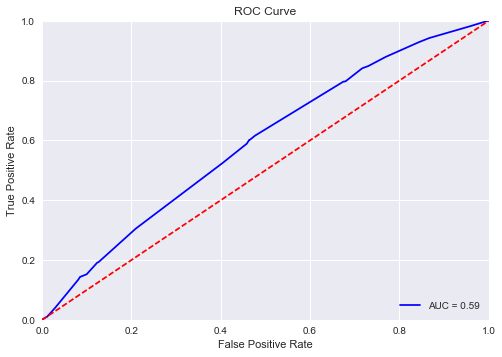

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year', 'lyrical_diversity']
params ={'criterion': ["gini","entropy"],
 'max_depth': [3, 5,7],
 'max_features': [3, 5,10],
 'min_samples_leaf': [ 3,5,10],
 'min_samples_split': [3,5,10],
 'class_weight':[{0:0.79516, 1:0.20484}]}
clf_dtree  = do_classify(DecisionTreeClassifier,params, top_ten_prediction, feature_cols, 'top_ten_hit',1)

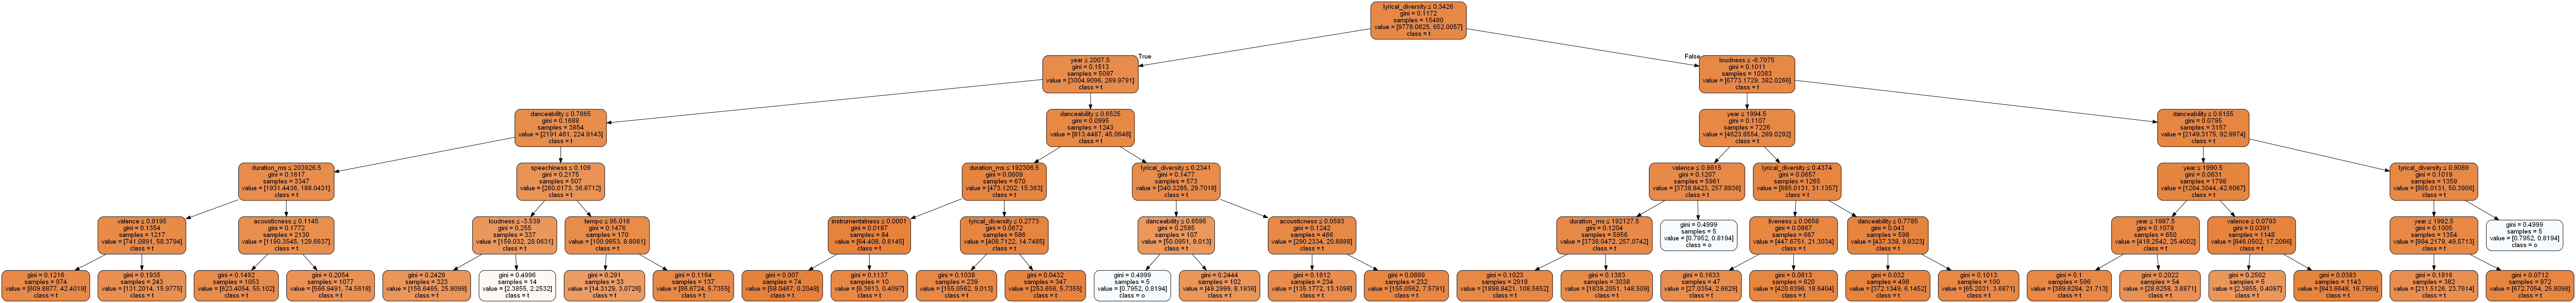

In [26]:
from IPython.display import Image 
import pydotplus
dot_data = export_graphviz(clf_dtree, out_file=None, 
                         feature_names=feature_cols,  
                         class_names='top_ten_hit',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

** Here the Decision Tree model improves on the area under the curve to a value of 0.59 compared to the Logistic Regression model AUC of 0.55. We investigate further with a random forest model. **

## Random Forest
A random forest is an ensemble method that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control for over-fitting.

BEST PARAMS {'class_weight': {0: 0.79516, 1: 0.20484}, 'max_depth': 5, 'n_estimators': 500}


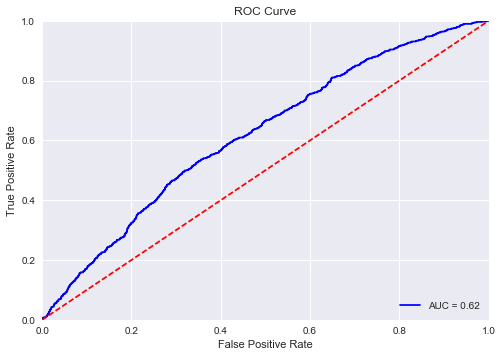

In [27]:
from sklearn.ensemble import RandomForestClassifier
params={'n_estimators':[500,1000],'max_depth':[5],'class_weight':[{0:0.79516, 1:0.20484}]}
clf_rf= do_classify(RandomForestClassifier, params, top_ten_prediction, feature_cols, 'top_ten_hit',1)

In [28]:
pd.DataFrame({"feature":feature_cols,"feature_importance":clf_rf.feature_importances_})

,feature,feature_importance
0,acousticness,0.04638
1,danceability,0.11164
2,duration_ms,0.06595
3,energy,0.04934
4,instrumentalness,0.03325
5,key,0.00921
6,liveness,0.05724
7,loudness,0.05860
8,mode,0.00536
9,speechiness,0.06534


The Random Forest Classification model results in an improved AUC of 0.62. The most important feature is lyrical diversity, followed by year and danceability. From this we see that lyrics can be a more important predictor of song popularity than we may have anticipated.

## Support Vector Machine Classification

Support vector machines  are a set of supervised learning methods used for classification, regression and outliers detection. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier.

For the parameters:
- C is the penalty parameter of the error term.
- degree is the degree of the polynomial kernel function.
- gamma is the kernel coefficient and when it is ‘auto’ then 1/n_features will be used.
- cache_size specifies the size of the kernel cache (in MB).
- max_iter when set to -1 mean there is no limit on the number of iterations within the solver.

BEST PARAMS {'C': 1, 'cache_size': 200, 'class_weight': {0: 0.79516, 1: 0.20484}, 'probability': True}


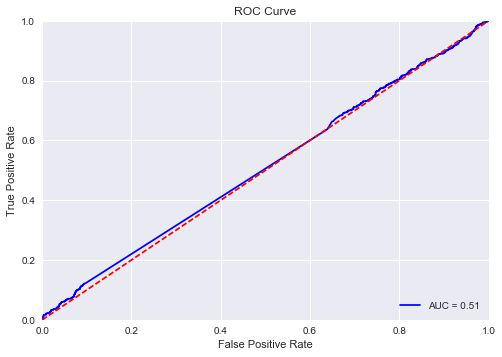

In [31]:
from sklearn.svm import SVC
params ={"C":[1],'cache_size':[200], 'probability':[True], 'class_weight':[{0:0.79516, 1:0.20484}]}
clf_svc=do_classify(SVC, params, top_ten_prediction, feature_cols, 'top_ten_hit',1)

The Support Vector Machine Classifier only gives a AUC of 0.51 and one of the downfalls of SVC is that it does not tell us much about which features are most important in the model.

## KNN 
The k-Nearest Neighbor (KNN) algorithm is used for classification or regression. During the training phase the KNN algorithm finds the $k$ “nearest” points to a given point, and returns the class with the highest proportion. If $k = 1$, then one only looks for the closest point and returns its class. The optimal value for $k$ in KNN is usually between 3-10. In our case $k$ is given by the parameter 'n_neighbors'.

BEST PARAMS {'n_neighbors': 3}


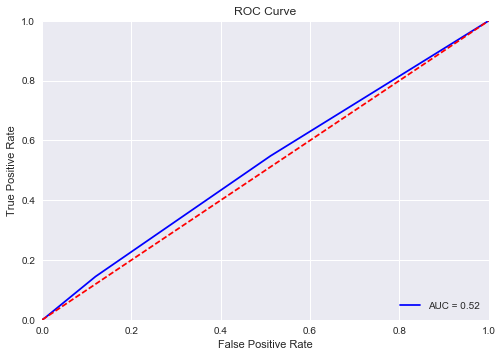

In [32]:
from sklearn.neighbors import KNeighborsClassifier
params ={'n_neighbors':[3,5,10]}
clf_knn = do_classify(KNeighborsClassifier, params, top_ten_prediction, feature_cols, 'top_ten_hit',1)

K-Nearest Neighbors gives a slightly better model than guessing, but its area under the curve is only 0.52 so it does not offer much improvement.

## Neural Network

For a supervised nueral network model we use Multi-layer Perceptron. It is a supervised learning algorithm that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where m is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. 

Multi-layer Perceptron is sensitive to feature scaling, so we will scale the data. 

For the neural network we will only define the hidden_layer_sizes. For this parameter you pass in a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. There are many ways to choose these numbers, but for simplicity we will choose 3 layers with the same number of neurons as there are features in our dataset.

BEST PARAMS {'hidden_layer_sizes': (10, 10, 10)}


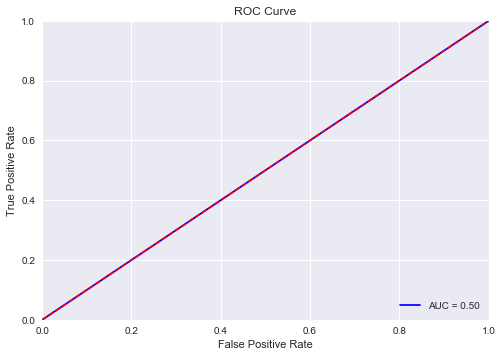

In [18]:
feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year', 'lyrical_diversity']
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
X=top_ten_prediction[feature_cols].values
y=top_ten_prediction['top_ten_hit'].values
Xtrain_nn, Xtest_nn, ytrain_nn, ytest_nn = train_test_split(X, y, test_size = 0.2, random_state=6)
# For the neural network we add the extra scaling step:
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(Xtrain_nn)
X_train_nn = scaler.transform(Xtrain_nn)
X_test_nn = scaler.transform(Xtest_nn)
#Use the classifier to fit the training data. We have 14 variables in our set
mlp = MLPClassifier()
parameters={'hidden_layer_sizes':[(10,10,10),(15,15,15),(20,20,20)]}
#mlp.fit(X_train_nn,ytrain_nn)
grid_clf = GridSearchCV(mlp, parameters, cv = 5, scoring = 'roc_auc')
# Use the classifier to fit the training data
grid_clf.fit(Xtrain_nn, ytrain_nn)
grid_est=grid_clf.best_estimator_
print("BEST PARAMS", grid_clf.best_params_)
mlp_model = grid_est.fit(Xtrain_nn, ytrain_nn)
predicted=mlp_model.predict_proba(Xtest_nn)[:,1]
fpr, tpr, threshhold = roc_curve(ytest_nn, predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Neural Network does not give a very accurate model with an essentially trivial AUC of 0.5.

## GBM Tree

Gradient Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. 

- learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. We want to choose a relatively high learning rate.
- min_samples_split is the minimum number of samples required to split an internal node and should be around ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
- min_samples_leaf is the minimum number of samples required to be at a leaf node and is used to prevent overfitting. We choose a small value again because of imbalanced classes.
- max_depth limits the number of nodes in the tree.
- max_features is the number of features to consider when looking for the best split. A general rule of thumb is to start with square root.

BEST PARAMS {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 150}


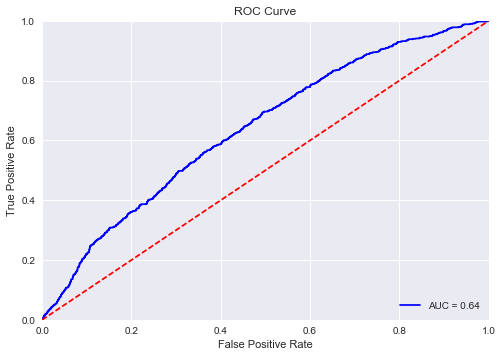

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
params ={'learning_rate':[0.05,0.1,0.2], 'min_samples_split':[150],'min_samples_leaf':[50],
         'max_depth':[3,5],'max_features':['sqrt',10]}
clf_gbm = do_classify(GradientBoostingClassifier, params, top_ten_prediction, feature_cols, 'top_ten_hit',1)

In [20]:
pd.DataFrame({"feature":feature_cols,"feature_importance":clf_gbm.feature_importances_})

,feature,feature_importance
0,acousticness,0.07102
1,danceability,0.08615
2,duration_ms,0.09624
3,energy,0.06375
4,instrumentalness,0.04150
5,key,0.01692
6,liveness,0.04449
7,loudness,0.07095
8,mode,0.00442
9,speechiness,0.06545


GBM Tree gives an AUC of 0.64, which is the largest of any model. Similar to the Random Forest Classifier lyrical diversity and year are the most important features, whereas in this case duration is the third most significant feature.

# Conclusion

From our investigation into key popularity we have found that the most popular keys have changed over time. C♯ has now become one of the most popular keys despite not being a very convenient key for piano and guitar. Throughout the history of the Billboard Hot 100, major keys have been more popular than minor keys. 

On the other hand lyrical diversity has steadily decreased on average over the years, and recently the most popular songs feature much more repetition than the other songs on the Billboard Hot 100. The difference in lyrical diversity of top ten songs and songs in the bottom ninety has led it to become one of the most important features in both the random forest and GBM Tree models.

The best performing models were the Random Forest Classifier and GBM classifier with area under the curve scores of 0.62 and 0.64 respectively. While these scores are not very high, the models still perform better than the trivial prediction. 

In the future it would be nice to incorporate the Million Song Dataset, which contians a measurement of artist "hotness" and genre, which could help to improve our model.